In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')


# Figure 1

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

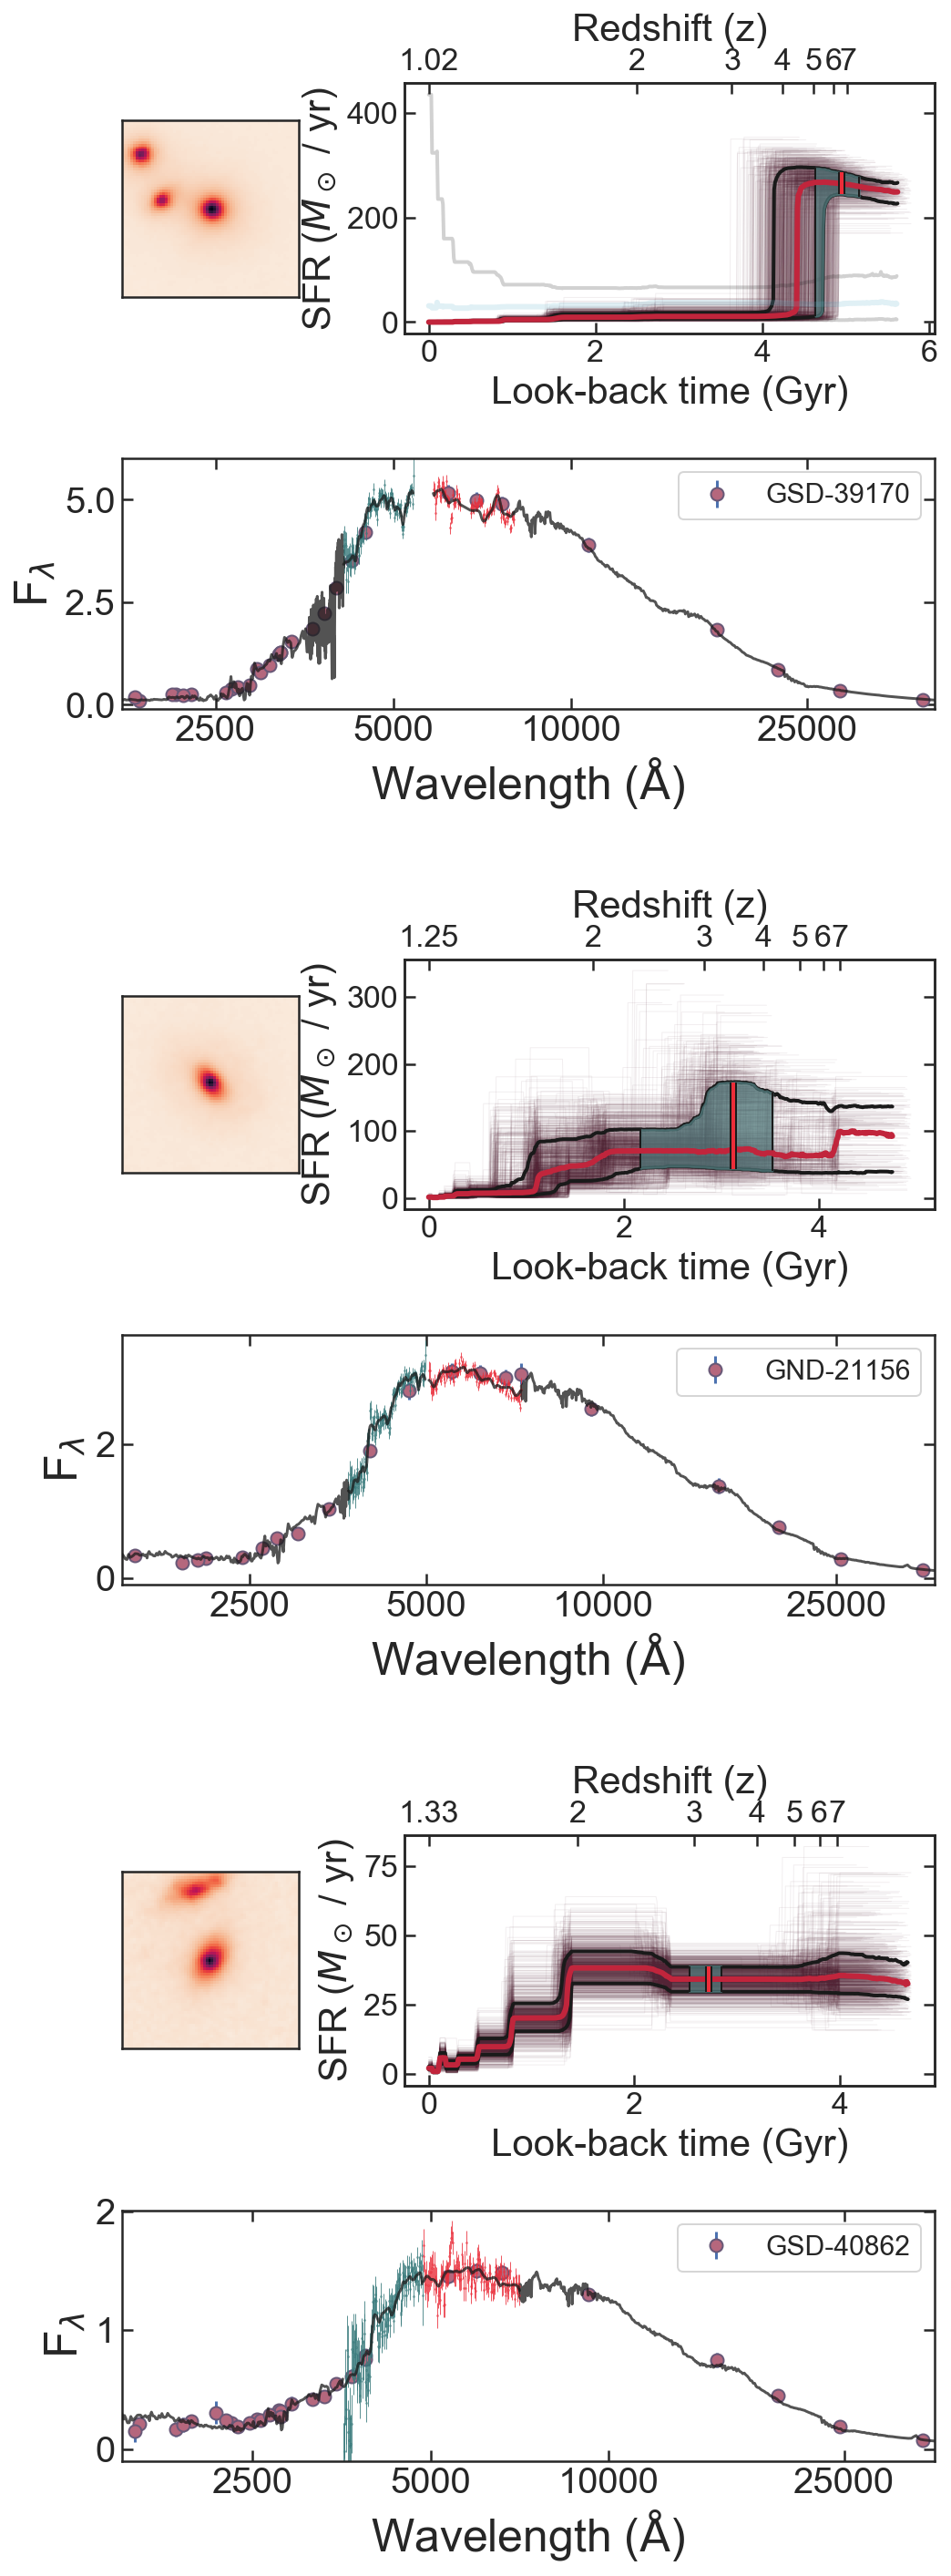

In [550]:

galaxies = [39170, 21156, 40862]

field = ['GSD','GND','GSD']

# galaxies = [39170]

# field = ['GSD']

gs = gridspec.GridSpec(3,1, hspace=0.4)
plt.figure(figsize =[8,24])

flip = True

for i in range(3):

    gsin = gridspec.GridSpecFromSubplotSpec(2,2, width_ratios=[1,3], subplot_spec= gs[i], hspace=0.5, wspace=0.3)

    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1 = plt.subplot(gsin[0,0])
    ax1.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(gsin[1,:])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

    if Gs.g102:
        ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field[i], galaxies[i]))

    ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
    ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
    ax2.legend(fontsize=15, frameon = True, loc = 1)
    ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
    ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    ax3 = plt.subplot(gsin[0,1])

    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax4 = ax3.twiny()

    ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

    if flip:  
        prior = Sfh_prior(field[i], galaxies[i])

        ax3.plot(prior.LBT,prior.SFH, color = 'c', linewidth = 3, zorder = 9, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_16, 'k', linewidth = 2, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_84, 'k', linewidth = 2, alpha = 0.2)
        flip = False
    
    
    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    zarray = [np.round(grow.zgrism.values[0],2)]

    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xticks(tarray)
    ax4.set_xticklabels(zarray)
    ax4.xaxis.set_ticks_position('top')

    ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax4.set_xlabel('Redshift (z)', fontsize=21) 
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)

plt.savefig('../plots/z_50_spec_sfh.pdf', bbox_inches = 'tight')

In [31]:
from spec_tools import Gen_PPF

class Sfh_prior(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []

        while idx < trials:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(draw[0]))
    
            time, sfr, tmax = convert_sfh(get_agebins(draw[0]), masses, maxage = draw[0]*1E9)

        
            T=[0]
            M=[0]
            for i in range(len(time)//2):
                mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                M.append(M[i] + mass)
                T.append(time[i*2+1])

            sfr = sfr/ M[-1] * 10**draw[1] / 1E9
        
            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]
        
            sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.array(sfr_grid)

# Figure 2

In [40]:
grism_wv,grism_ratio= np.load('../data/plot_points/grism_ratio.npy')
phot_wv,phot_ratio= np.load('../data/plot_points/phot_ratio.npy')
LBT1,SFH1= np.load('../data/plot_points/SFH1.npy')
LBT2,SFH2 = np.load('../data/plot_points/SFH2.npy')

[0.125 0.125]


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


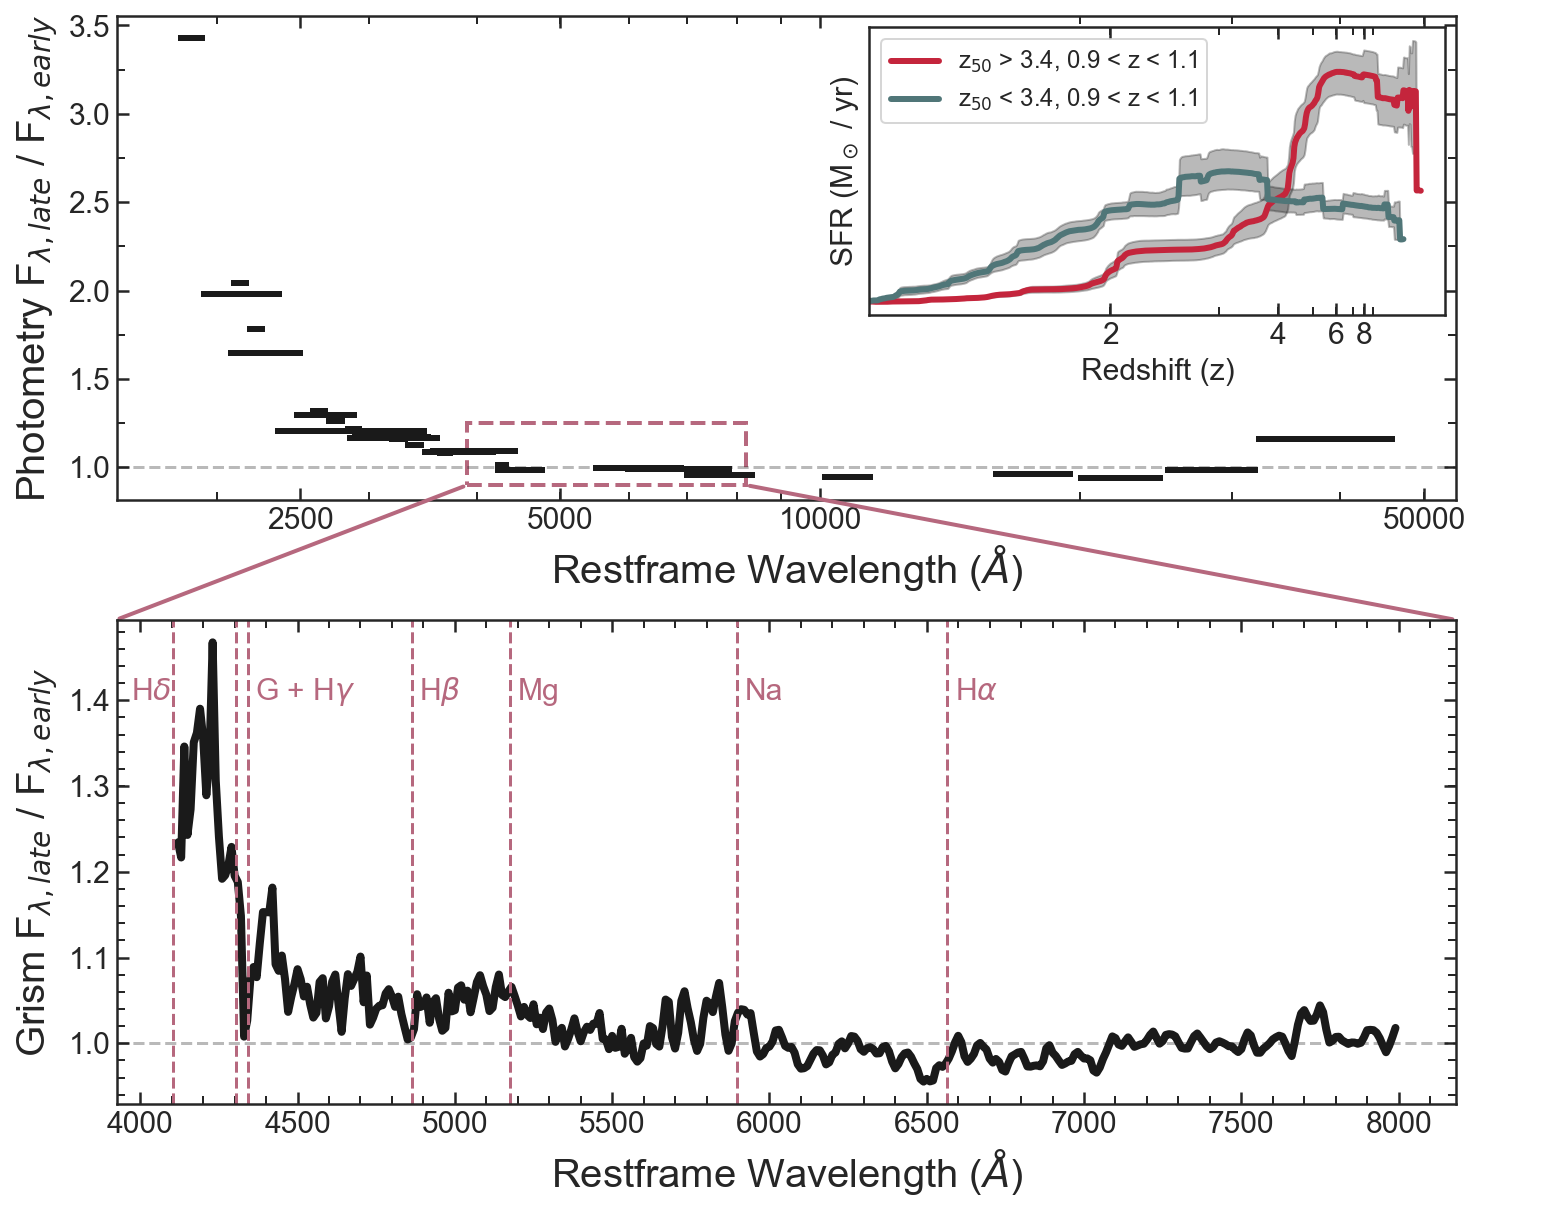

In [634]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.ticker import AutoMinorLocator


gs = gridspec.GridSpec(2,1,hspace=0.25,wspace=0.2)

plt.figure(figsize=[12,10])


ax1=plt.subplot(gs[0])

# plt.plot(10**phot_wv,phot_ratio, 'k',linewidth = 4, alpha = 0.2)
plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)
ax1.set_xticks([2000,3000,3500,4000,4500,6000,7000,8000,9000,20000,30000,40000], minor = True)
ax1.set_yticks([1.25,1.75,2.25,2.75,3.25], minor = True)
ipratio = interp1d(10**phot_wv,phot_ratio)

for i in range(len(Pnum)):
    for ii in range(len(MDF)):
        if Pnum[i] == MDF.tmp_num[MDF.index[ii]]:
#             print(MDF.eff_wv[MDF.index[ii]],FWHM(ii))
            try:
                plt.errorbar(MDF.eff_wv[MDF.index[ii]] / 2, ipratio(MDF.eff_wv[MDF.index[ii]] / 2),
                             xerr = FWHM(ii)/2, color='k', elinewidth=3)
            except:
                pass

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Photometry F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xscale('log')
plt.xticks([2500,5000,10000,50000],[2500,5000,10000,50000])

ax2 = plt.subplot(gs[1])
plt.plot(grism_wv,grism_ratio, 'k',linewidth = 4)
plt.axvline(4102.89 ,linestyle='--', color = '#B6687E')
plt.axvline(4305.61 ,linestyle='--', color = '#B6687E')
plt.axvline(4341.68 ,linestyle='--', color = '#B6687E')
plt.axvline(4862.68 ,linestyle='--', color = '#B6687E')
plt.axvline(5176.7,linestyle='--', color = '#B6687E')
plt.axvline(5895.6,linestyle='--', color = '#B6687E')
plt.axvline(6564.61,linestyle='--', color = '#B6687E')

ax2.text(3970, 1.4, 'H$\delta$' , color = '#B6687E', fontsize=15)
plt.text(4365, 1.4, 'G + H$\gamma$' , color = '#B6687E', fontsize=15)
plt.text(4885, 1.4, 'H$\\beta$' , color = '#B6687E', fontsize=15)
plt.text(5200, 1.4, 'Mg' , color = '#B6687E', fontsize=15)
plt.text(5920, 1.4, 'Na', color = '#B6687E', fontsize=15)
plt.text(6590, 1.4, 'H$\\alpha$' , color = '#B6687E', fontsize=15)

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Grism F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)
plt.minorticks_on()

axins = inset_axes(ax1, width=4, height=2)

zoomingBox(ax1, [3900,8200,0.9,1.25], ax2)

LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)
SFH_grid = []

for i in mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)
plt.plot(L, S / np.trapz(S,L), '#C4253C', linewidth = 3,label = 'z$_{50}$ > 3.4, 0.9 < z < 1.1')
plt.fill_between(L, S16 / np.trapz(S,L), S84 / np.trapz(S,L), color = 'k', alpha = 0.3)

SFH_grid = []
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 < 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)
plt.plot(L, S / np.trapz(S,L), '#507678', linewidth = 3,label = 'z$_{50}$ < 3.4, 0.9 < z < 1.1')
plt.fill_between(L, S16 / np.trapz(S,L), S84 / np.trapz(S,L), color = 'k', alpha = 0.3)

plt.xticks(cosmo.lookback_time([1,2,4,6,8]).value,[1,2,4,6,8])
axins.set_xticks(cosmo.lookback_time([1,2,3,4,5,6,7,8,9]).value, minor = True)

plt.xlim(8,14)
plt.yticks([])
# plt.minorticks_on()

plt.xlabel('Redshift (z)', fontsize=15)
plt.ylabel('SFR (M$_\odot$ / yr)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.savefig('../plots/SFH_summary.pdf', bbox_inches = 'tight')

In [124]:
from matplotlib.patches import Rectangle

def zoomingBox(ax1, roi, ax2, color='#B6687E', linewidth=2):
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2],**dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)]) ))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    print(dstCorners[0])
    
    dstCorners[0] = [0.075, 0.125]
    dstCorners[1] = [0.075, 0.488]
    dstCorners[2] = [0.90, 0.125]
    dstCorners[3] = [0.944, 0.488]
    
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', 
                     arrowprops=dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)]))

In [221]:
bfilters = [34, 36, 37, 58, 117, 118, 195, 196, 220, 224]

MDF = pd.read_pickle('../phot/model_photometry_list.pkl')
SWV, TR = np.load('../templates/master_tmp.npy')
W, F, E, Pnum = np.load('../phot/GSD_39170_phot.npy')
     
WRF = W / (1 + 1)

IDX = []

for i in range(len(Pnum)):
    if Pnum[i] not in bfilters and F[i] / E[i] > 0.5:
        IDX.append(i)

W, WRF, F, E, Pnum = W[IDX], WRF[IDX], F[IDX], E[IDX], Pnum[IDX]

W, WRF, F, E, Pnum = W[F > 0], WRF[F > 0], F[F > 0], E[F > 0], Pnum[F > 0]
        
IDP = []
for i in range(len(Pnum)):
    for ii in range(len(MDF)):
        if Pnum[i] == MDF.tmp_num[MDF.index[ii]]:
            IDP.append(ii)

In [157]:
def FWHM(idx):
    flip = 0
    for i in range(len(SWV[idx])):
        if flip == 0 and TR[idx][i]-0.5 > 0:
            llim = SWV[idx][i]
            flip = 1

        if flip == 1 and TR[idx][i]-0.5 < 0:
            hlim = SWV[idx][i]
            flip = 0
    return (hlim - llim)/2

1) observed at redshift 1

2) late former, z_50 = 2.5, age = 3.54

3) early former, z_50 = 4.5, age = 4.83

In [398]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.5, dust_type = 1)

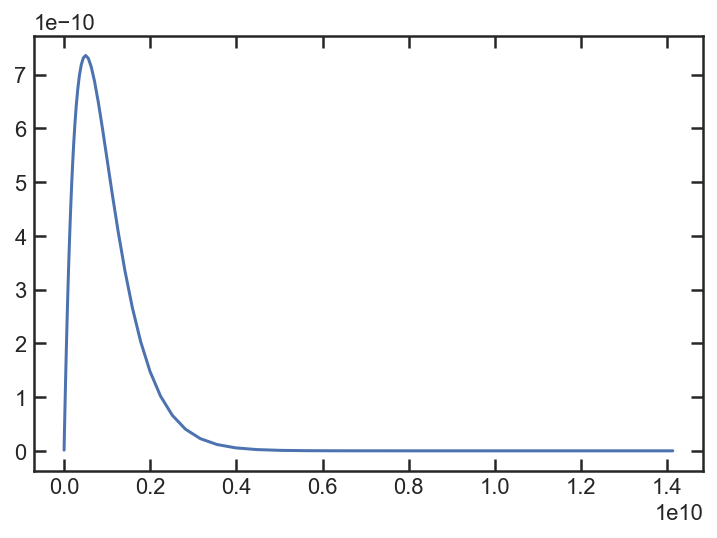

In [244]:
plt.plot(10**sp.log_age, sp.sfr)

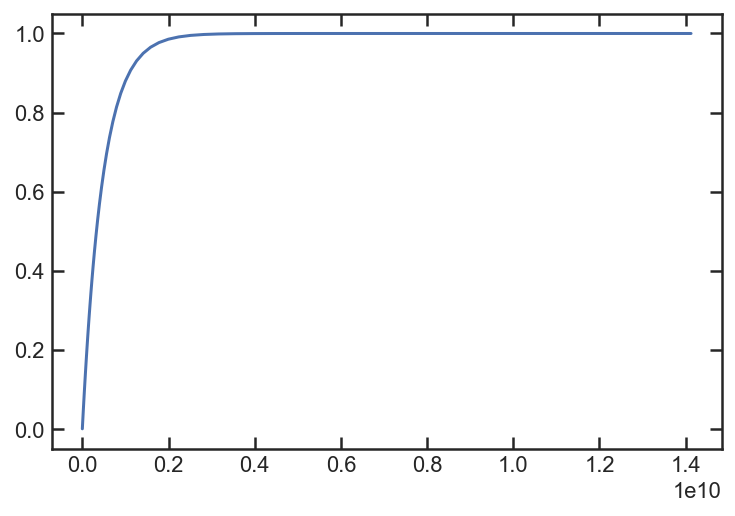

In [245]:
plt.plot(10**sp.log_age, np.cumsum(sp.sfr) /np.cumsum(sp.sfr)[-1] )

In [246]:
interp1d(np.cumsum(sp.sfr) /np.cumsum(sp.sfr)[-1],10**sp.log_age)(0.5)

array(3.27851758e+08)

In [280]:
0.3, cosmo.age(0.98) - cosmo.age(2.68), cosmo.age(1.02) - cosmo.age(4.43)

(0.3, <Quantity 3.51361217 Gyr>, <Quantity 4.42027352 Gyr>)

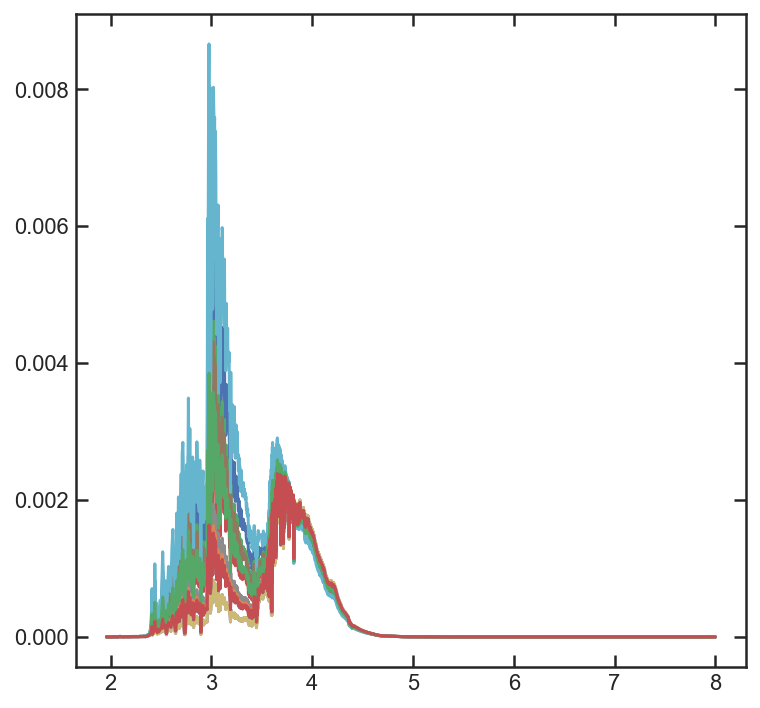

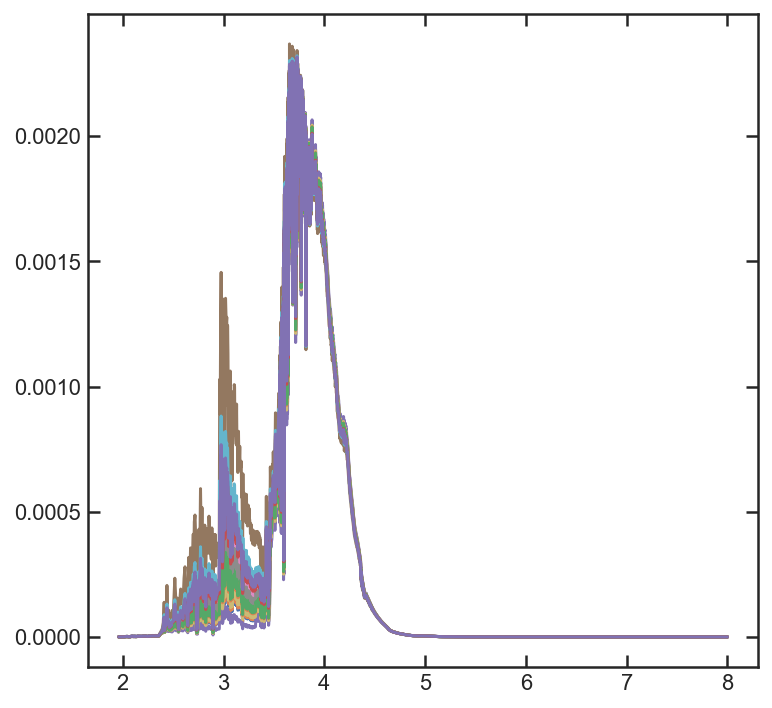

In [406]:
fl_late = np.zeros_like(wv)
plt.figure(figsize=[6,6])
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 < 3.4').index:
    wv,fl = sp.get_spectrum(tage=cosmo.age(mdb.zgrism[i]).value - cosmo.age(mdb.z_50[i]).value + 0.3, peraa=True)
    
    IDX = [U for U in range(len(wv)) if 6000 < wv[U] < 6500]
    Nfact = np.trapz(fl[IDX],wv[IDX])
    fl_late += fl/Nfact
    plt.plot(np.log10(wv),fl/Nfact)
    
fl_early = np.zeros_like(wv)
plt.figure(figsize=[6,6])
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').index:
    wv,fl = sp.get_spectrum(tage=cosmo.age(mdb.zgrism[i]).value - cosmo.age(mdb.z_50[i]).value + 0.3, peraa=True)
    
    IDX = [U for U in range(len(wv)) if 6000 < wv[U] < 6500]
    Nfact = np.trapz(fl[IDX],wv[IDX])
    fl_early += fl/Nfact
    plt.plot(np.log10(wv),fl/Nfact)

(0.85, 1.35)

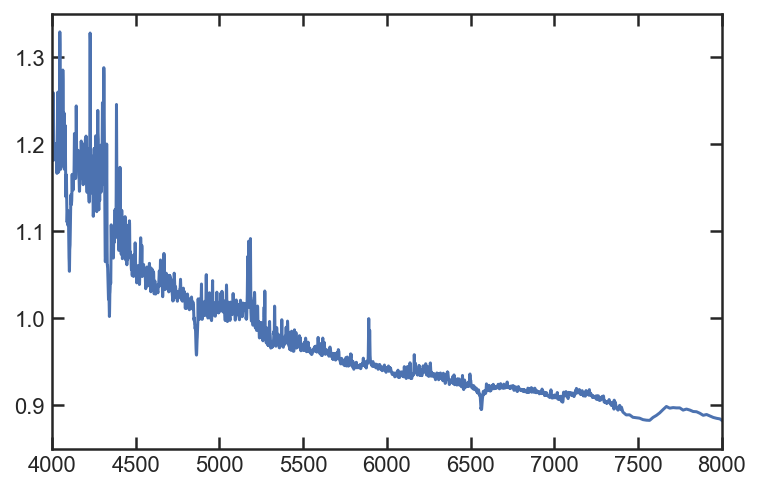

In [415]:
plt.plot(wv,fl_late / fl_early)
plt.xlim(4000,8000)
plt.ylim(0.85,1.35)

In [281]:
wv1,fl1 = sp.get_spectrum(tage=3.81, peraa=True)
wv2,fl2 = sp.get_spectrum(tage=4.72, peraa=True)

(1.3, 1.8)

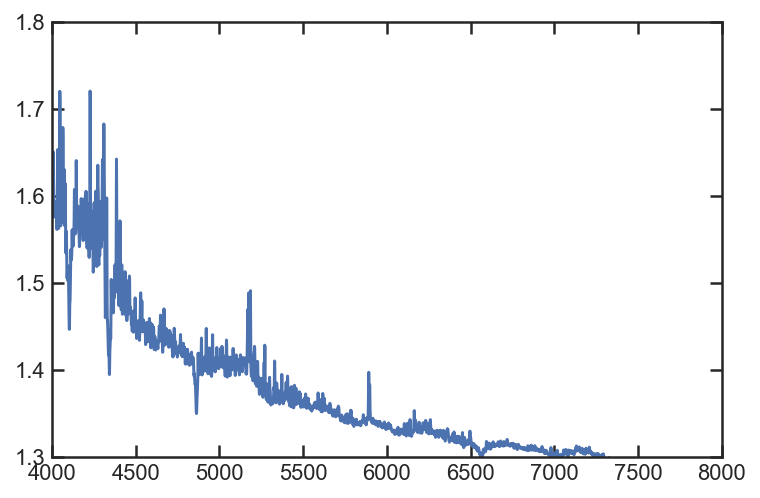

In [282]:
plt.plot(wv1,fl1/fl2)
# plt.plot(wv2,fl2)
# plt.xscale('log')
plt.xlim(4000,8000)
plt.ylim(1.3,1.8)

In [279]:
np.median(mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').zgrism)

1.0206983360885422

In [310]:
Gs = Gen_spec('GND', 17070, 1.023, phot_errterm = 0.04, irac_err = 0.08,g102_lims=[8300, 11400], g141_lims=[11200, 16500]) 


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [311]:
Gs.Full_forward_model(wv1,fl1,1.023)
Bmfl1 = Gs.Bmfl
Rmfl1 = Gs.Rmfl

Gs.Full_forward_model(wv2,fl2,1.023)
Bmfl2 = Gs.Bmfl
Rmfl2 = Gs.Rmfl

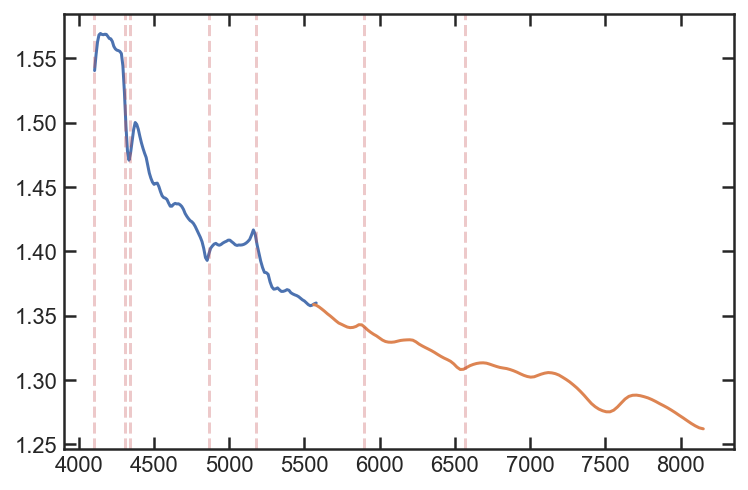

In [313]:
plt.plot(Gs.Bwv_rf,Bmfl1/Bmfl2)
plt.plot(Gs.Rwv_rf,Rmfl1/Rmfl2)
plt.axvline(4102.89 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4305.61 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(5176.7,linestyle='--', alpha=.3, color = 'r')
plt.axvline(5895.6,linestyle='--', alpha=.3, color = 'r')
plt.axvline(6564.61,linestyle='--', alpha=.3, color = 'r')

# plt.plot(Gs.Bwv_rf,Bmfl2)

# Figure 3

In [326]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
fast_GSD = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout', format = 'ascii').to_pandas()
fast_GND = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout', format = 'ascii').to_pandas()
ez_3d_GSD = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout', format = 'ascii').to_pandas()
ez_3d_GND = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout', format = 'ascii').to_pandas()

Text(0,0.5,'FAST lmass')

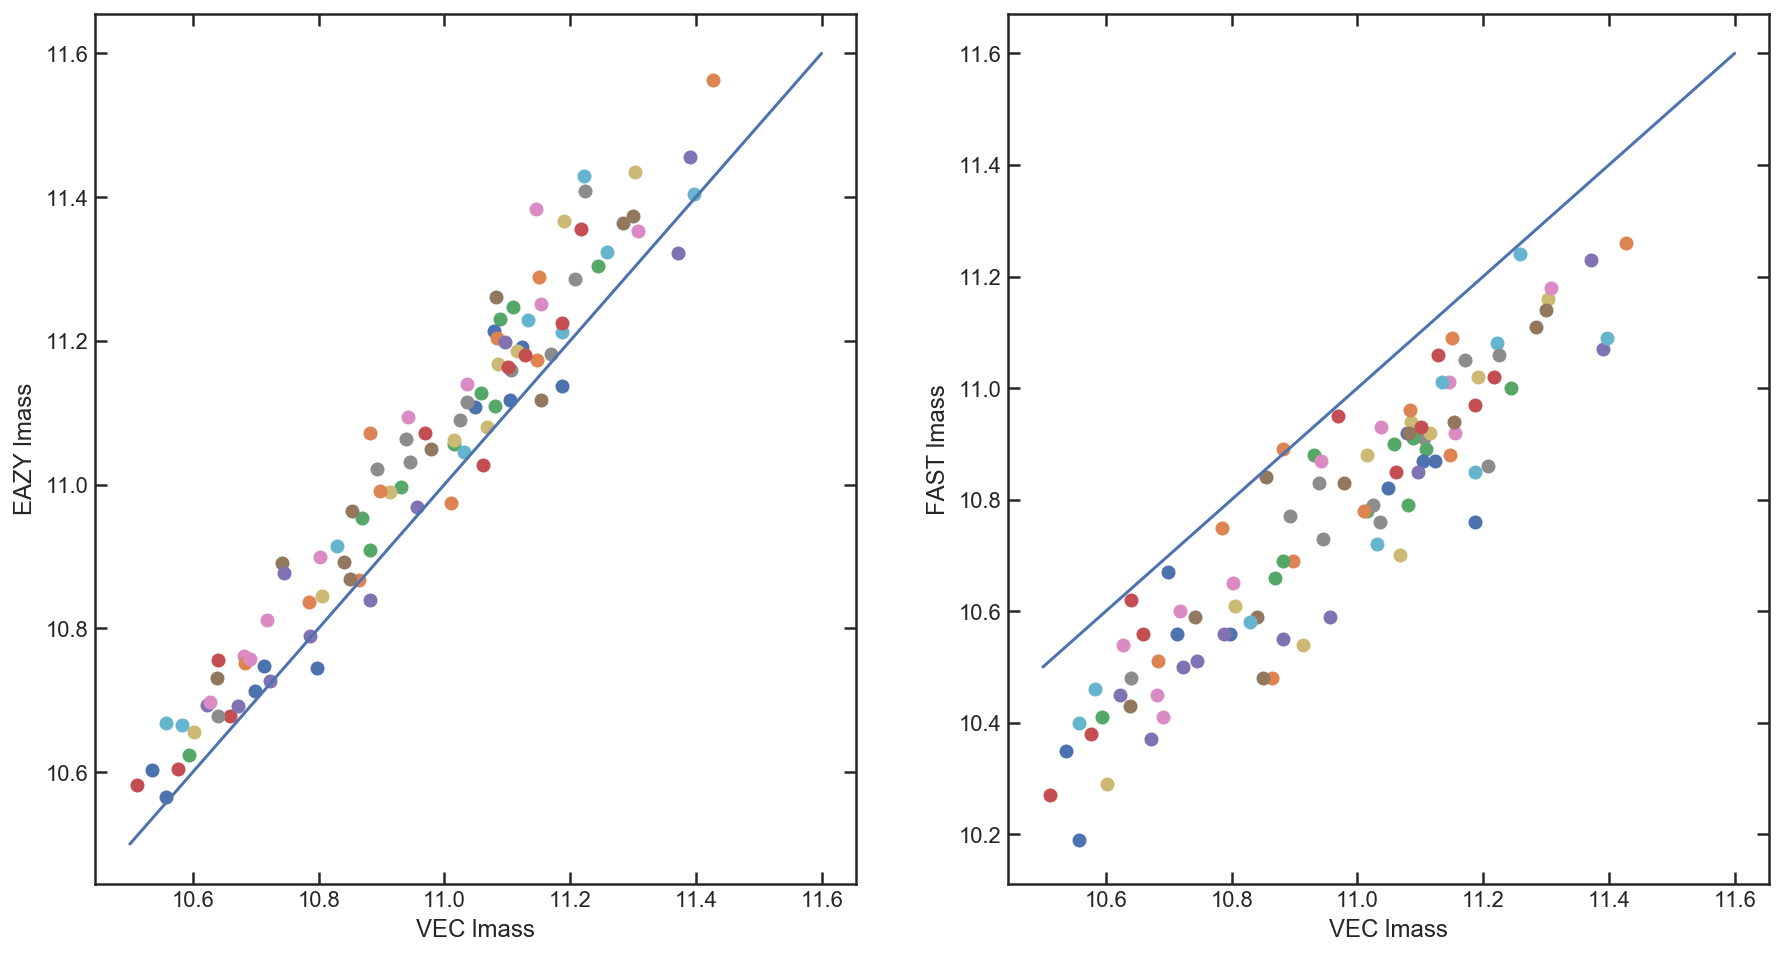

In [324]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezmass = np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0])
        fsmass = fast_GSD.query('id == {}'.format(mdb.id[i])).lmass.values[0]
    else:
        ezmass = np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0])
        fsmass = fast_GND.query('id == {}'.format(mdb.id[i])).lmass.values[0]
        
    ax1.scatter(mdb.lmass[i], ezmass)
    ax2.scatter(mdb.lmass[i], fsmass)

ax1.plot([10.5,11.6],[10.5,11.6])
ax2.plot([10.5,11.6],[10.5,11.6])

ax1.set_xlabel('VEC lmass')
ax2.set_xlabel('VEC lmass')

ax1.set_ylabel('EAZY lmass')
ax2.set_ylabel('FAST lmass')

Text(0,0.5,'3D-HST redshift')

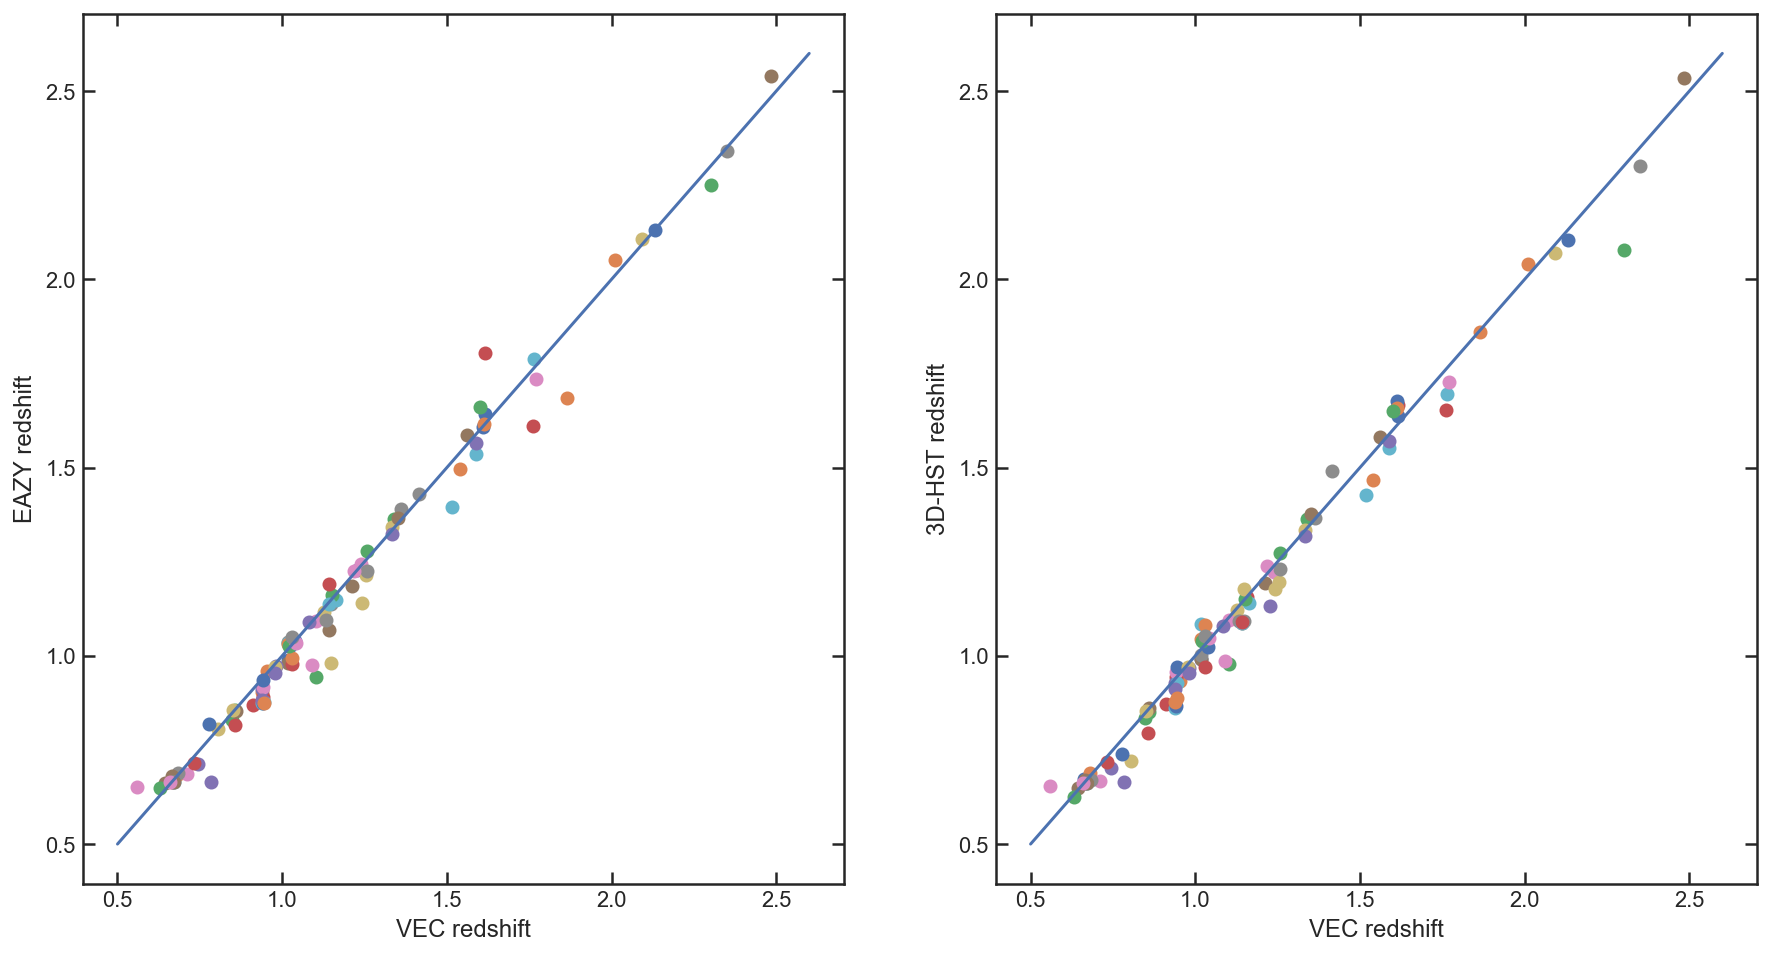

In [327]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezrshift = eazy_GSD.query('id == {}'.format(mdb.id[i])).z500.values[0]
        fsrshift = ez_3d_GSD.query('id == {}'.format(mdb.id[i])).z_peak.values[0]
    else:
        ezrshift = eazy_GND.query('id == {}'.format(mdb.id[i])).z500.values[0]
        fsrshift = ez_3d_GND.query('id == {}'.format(mdb.id[i])).z_peak.values[0]
        
    ax1.scatter(mdb.zgrism[i], ezrshift)
    ax2.scatter(mdb.zgrism[i], fsrshift)

ax1.plot([0.5,2.6],[0.5,2.6])
ax2.plot([0.5,2.6],[0.5,2.6])

ax1.set_xlabel('VEC redshift')
ax2.set_xlabel('VEC redshift')

ax1.set_ylabel('EAZY redshift')
ax2.set_ylabel('3D-HST redshift')

2
6
10
14


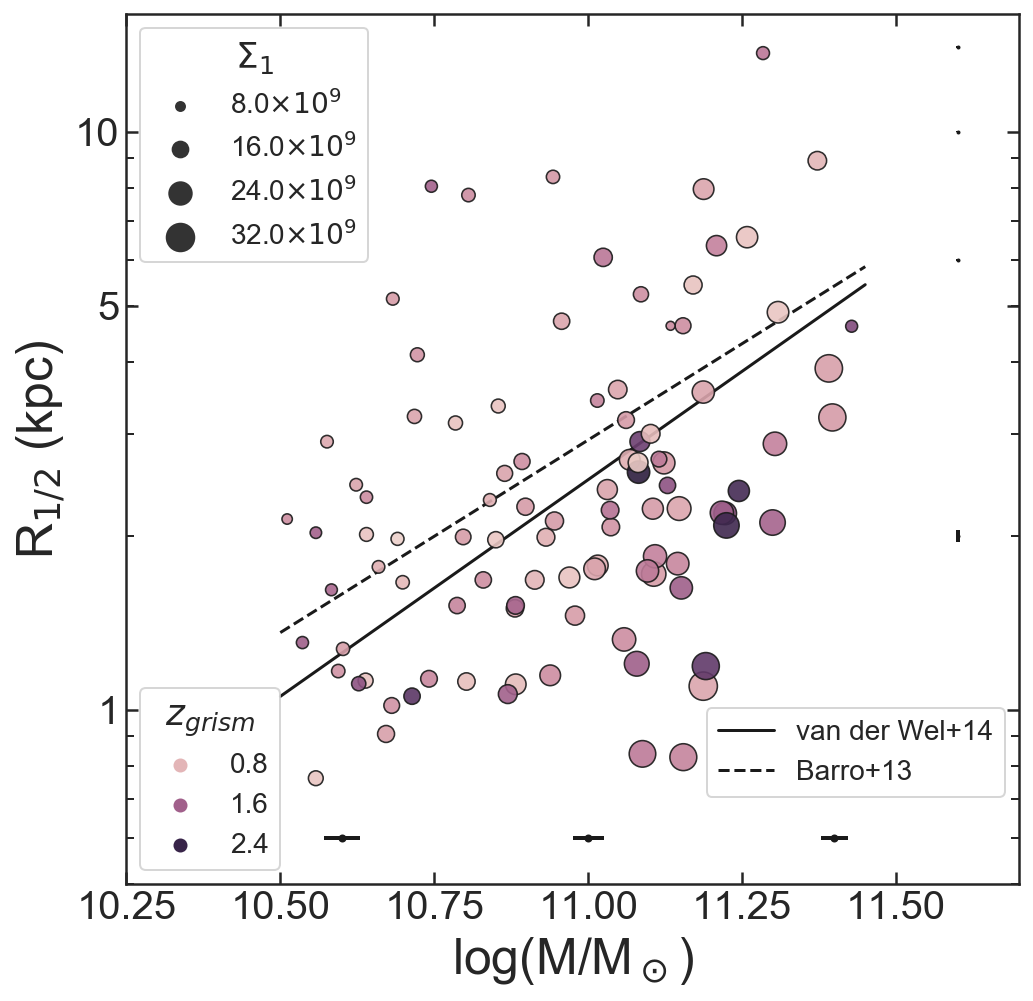

In [381]:
lowlim = 10.4
lm_errbin = []

while lowlim < 11.6:
    lowerr = []
    hierr = []
    for i in mdb.index:
        if lowlim < mdb.lmass[i] < lowlim + 0.4:
            for ii in range(len(mdb.lmass_hci[i])//2):
                if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
                    lowerr.append(mdb.lmass_hci[i][2*ii])
                    hierr.append(mdb.lmass_hci[i][2*ii+1])
       
    lm_errbin.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    
    lowlim += 0.4
    
    
lowlim = 0
Re_errbin = []

while lowlim < 15:
    
    print(lowlim + 2)
    sig = []
    for i in mdb.index:
        if lowlim < mdb.Re[i] < lowlim + 4:
            sig.append(mdb.Re_sig[i])
       
    Re_errbin.append(np.median(sig))
    
    
    lowlim += 4
    
def A_limit(mass, Alimit):
    return Alimit * (mass / 1E11)**0.75

def B_limit(mass, Blimit):
    return (mass / Blimit)**(1/1.5)


plt.figure(figsize=[8,8])
ax = plt.subplot()
    
g = sea.scatterplot(mdb.lmass, mdb.Re, color = '#507678',
                hue = mdb.zgrism, 
                size= mdb.Sigma1,
                sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9, linewidth = 0.8, edgecolor = 'k', zorder =5)


lml = []
lmh = []
lm = []
for i in mdb.index:
    for ii in range(len(mdb.lmass_hci[i])//2):
        if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
            lml.append(mdb.lmass[i] - mdb.lmass_hci[i][2*ii])
            lmh.append(mdb.lmass_hci[i][2*ii+1] - mdb.lmass[i])
            lm.append(mdb.lmass[i])

mass = 10**np.linspace(10.5,11.45)
            
plt.plot(np.log10(mass), A_limit(mass, 2.5), 'k', label = 'Van der Wel+14')
plt.plot(np.log10(mass), B_limit(mass, 10**10.3),'--k', label = 'Barro+17')

handles, _ = ax.get_legend_handles_labels()
l2 = plt.legend(handles[:2], ['van der Wel+14','Barro+13'], fontsize = 14, loc = [0.65,0.1])
ax.add_artist(l2)
l3 = plt.legend(handles[9:], ['8.0$\\times 10^9$','16.0$\\times 10^9$','24.0$\\times 10^9$','32.0$\\times 10^9$'],title = '$\Sigma_1$', 
          loc = 2,fontsize = 14)
ax.add_artist(l3)
ax.get_legend().get_title().set_fontsize('18')

ax.legend(handles[4:], ['0.8','1.6','2.4'],title = '$z_{grism}$', 
          loc = 3,fontsize = 14)
ax.get_legend().get_title().set_fontsize('18')

plt.errorbar([10.6,11.0,11.4],[0.6,0.6,0.6], xerr=lm_errbin, fmt = 'o',ms=3, color = 'k', elinewidth=2)
plt.errorbar([11.6, 11.6, 11.6, 11.6],[2,6,10,14], yerr=Re_errbin, fmt = 'o',ms=1, color = 'k', elinewidth=2)

plt.ylim(0.5,16)   
plt.yscale('log')
plt.yticks([1,5,10],[1,5,10], zorder =1)
plt.ylabel('R$_{1/2}$ (kpc)', fontsize=25)
plt.xlabel('log(M/M$_\odot$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(10.25,11.7)
plt.savefig('../plots/r_lm.pdf', bbox_inches = 'tight')

In [375]:
np.log10(32E9)

10.505149978319906

### Barro $\Sigma_1$

$\log \Sigma_{1kpc} - \log M_* = -\log \pi - \log \gamma(2n, b_nr_e^{-1/n})$

$ \log \gamma(2n, b_nr_e^{-1/n}) = c_0 + c_1 \log r_e + c_2(\log r_e)^2$

$n = 4; c_0 = 0.30; c_1 = 0.56; c_2 = 0.29$

$n = 3; c_0 = 0.30; c_1 = 0.63; c_2 = 0.36$

$n = 2; c_0 = 0.30; c_1 = 0.75; c_2 = 0.49$

$n = 1; c_0 = 0.31; c_1 = 0.96; c_2 = 0.75$

In [356]:
def log_gamma(n, re):
    if np.round(n)==4:
        C = [0.3, 0.56, 0.29]
    if np.round(n)==3:
        C = [0.3, 0.63, 0.36]
    if np.round(n)==2:
        C = [0.3, 0.75, 0.49]
    if np.round(n)==1:
        C = [0.31, 0.96, 0.75]
        
    return C[0] + C[1] * np.log10(re) + C[2] * np.log10(re)**2

def log_sigma1(M, n, re):
    return -np.log10(np.pi) - log_gamma(n, re) + np.log10(M)

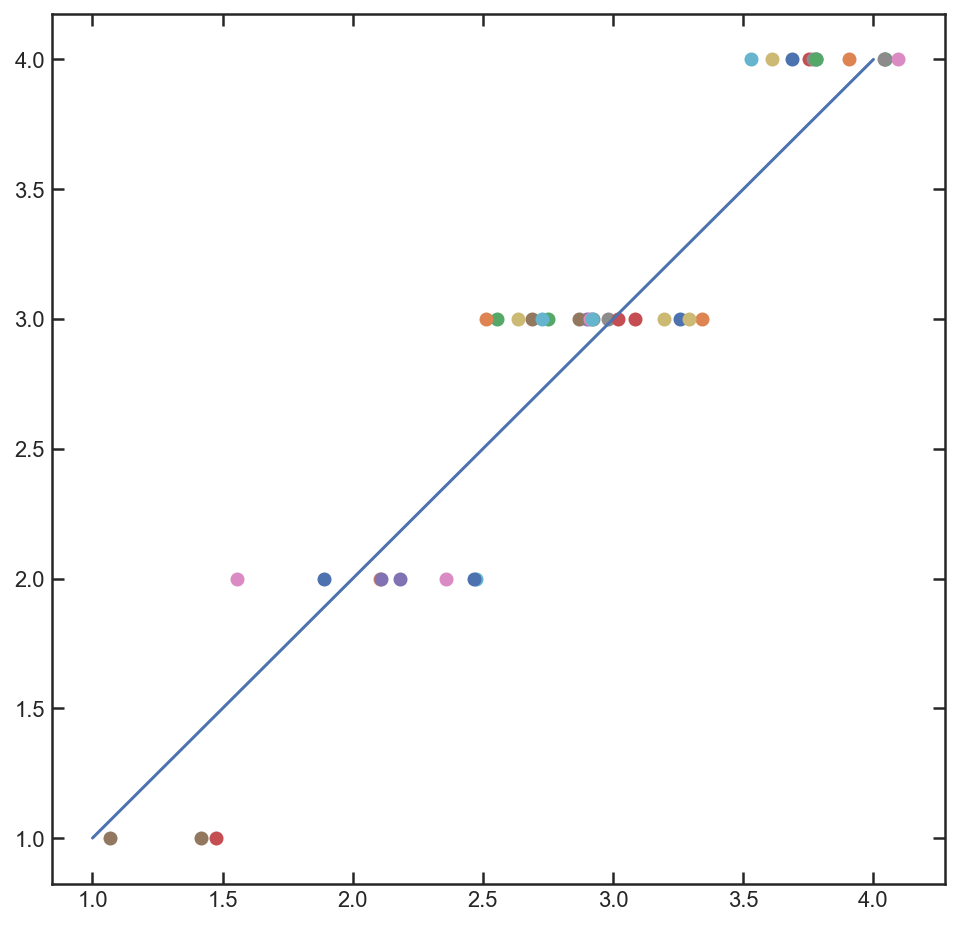

In [355]:
plt.figure(figsize=[8,8])
for i in mdb.query('n < 4.1').index:
    plt.scatter(mdb.n[i], np.round(mdb.n[i]))
plt.plot([1,4],[1,4])

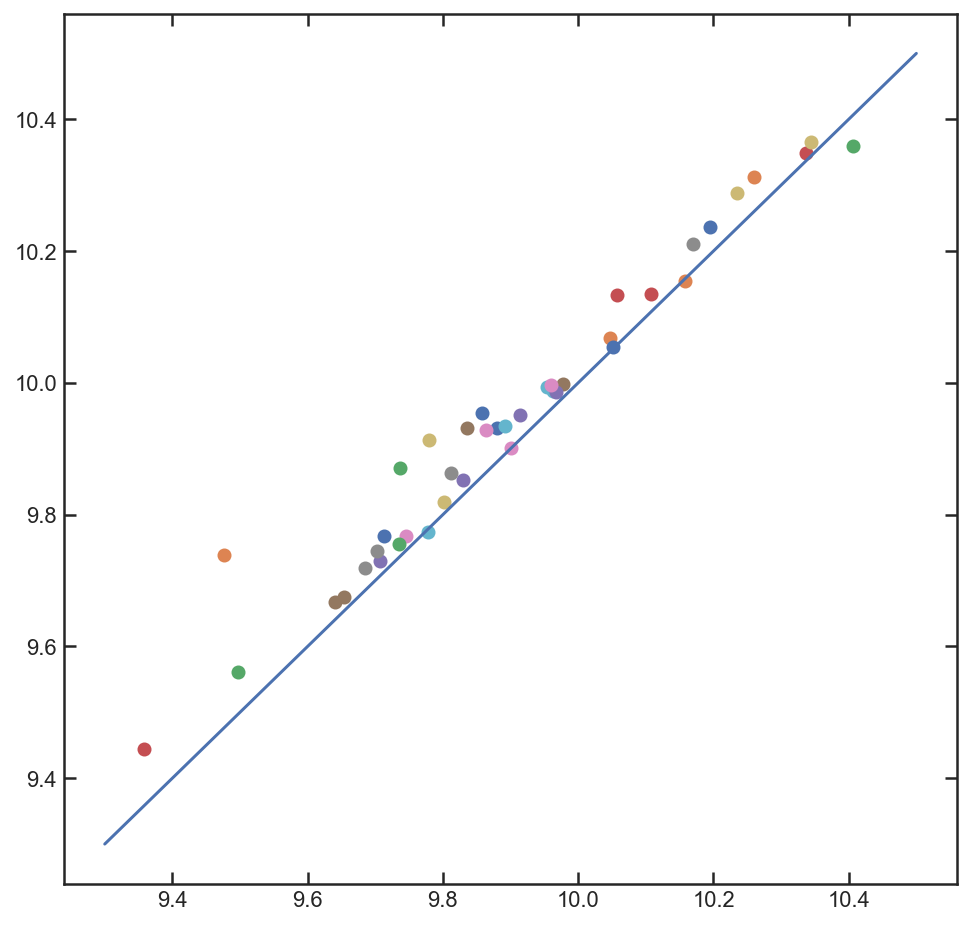

In [358]:
plt.figure(figsize=[8,8])
res = []
for i in mdb.query('n < 4.1').index:
#     print(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i]))
#     print(np.log10(mdb.Sigma1[i]))
    
    plt.scatter(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i]),np.log10(mdb.Sigma1[i]))
    res.append(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i])-np.log10(mdb.Sigma1[i]))
plt.plot([9.3,10.5],[9.3,10.5])

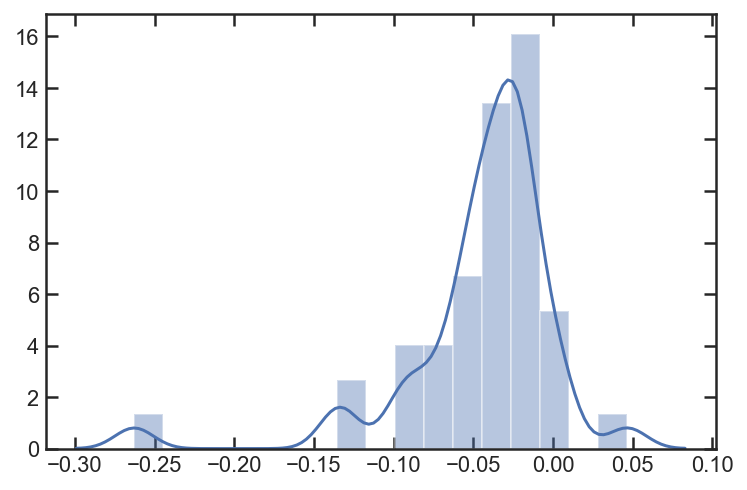

In [359]:
sea.distplot(res)

# Figure 4

(7, 11)

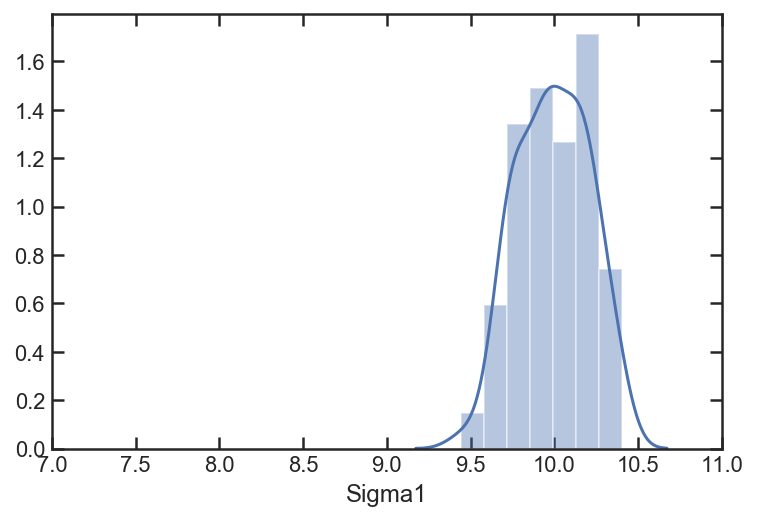

In [333]:
sea.distplot(np.log10(mdb.Sigma1))
plt.xlim(7,11)

# Figure 5

In [484]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)
    ################
    stack = np.zeros(len(lbt))
    for i in range(len(lbt)):
#         weights = len(sfhgrid[i][sfhgrid[i] > 0])
        stack[i] = np.mean(sfhgrid[i])        
#         stack[i] = np.median(sfhgrid[i])        

    return stack

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


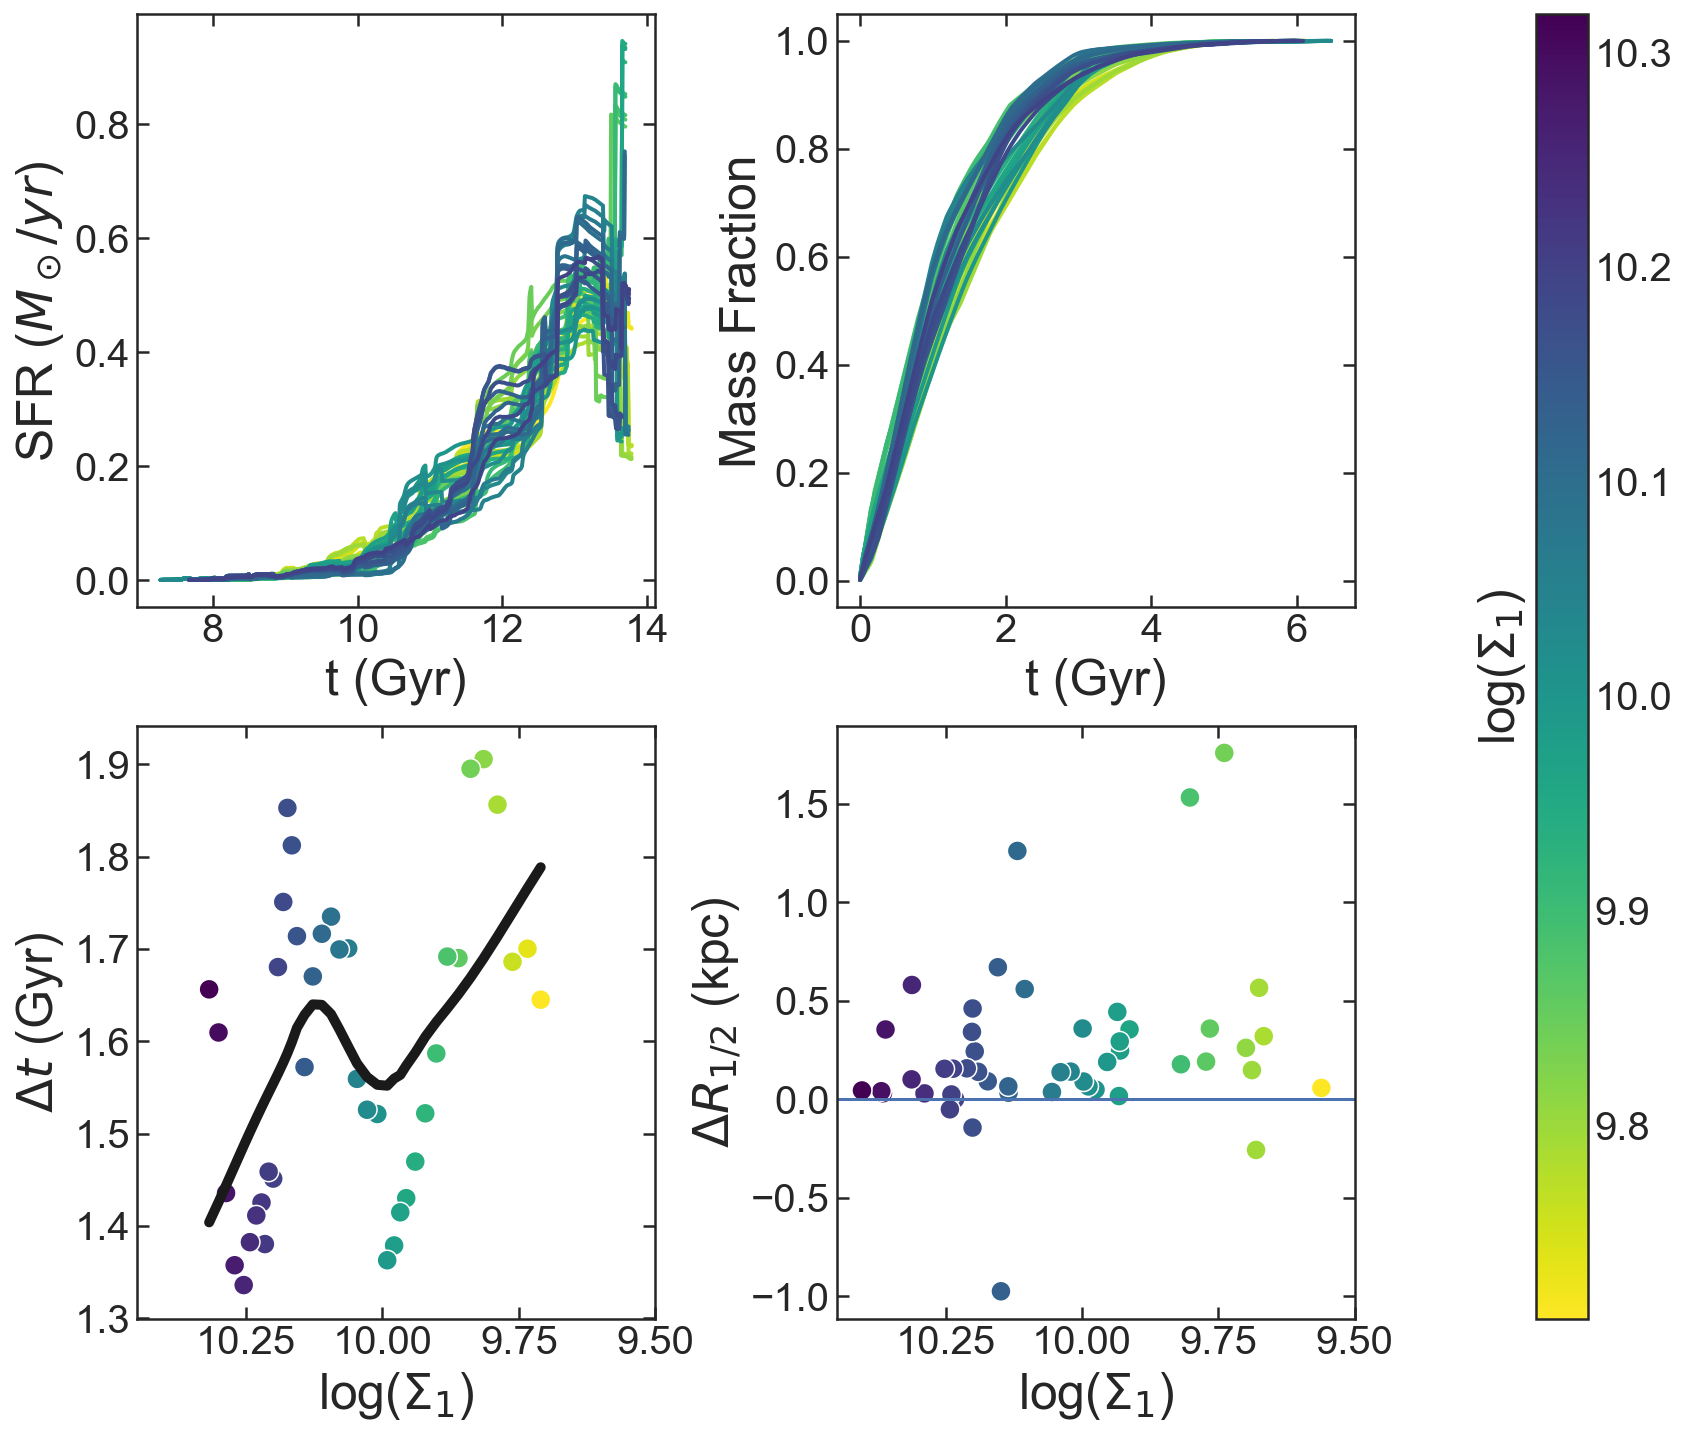

In [663]:
#import colormap
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(Smdb))

IDS = Smdb.index.values

bs =9

gs = gridspec.GridSpec(2,3, wspace=0.5, width_ratios=[1,1,0.1])

plt.figure(figsize =[13,12])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])

idx = 0

t50 = []
t90 = []
s1 = []

LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

for i in range(len(IDS) - bs):
    SFH_grid = []
    
    for ii in range(bs):
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[IDS[i + ii]], mdb.id[IDS[i + ii]]))

        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[IDS[i + ii]]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

    L,S= Stack_SFH(LBT, SFH_grid)
    
    ax1.plot(L, S/np.trapz(S,L), linewidth = 2,color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255 )
    ax2.plot(L - min(L), np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])), linewidth = 2, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255)
    idx+=1
    
    mb = interp1d(np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])),L - min(L))
    t50.append(mb(0.5))
    t90.append(mb(0.9))
    samp = []
    for ii in range(bs+1):
        samp.append(Smdb.Sigma1[IDS[i + ii]])
        
    s1.append(np.mean(samp))
    
sea.regplot(np.log10(s1),np.array(t90)-np.array(t50),lowess=True, scatter=False,line_kws={"linewidth" : 5}, color='k')
# for i in range(len(IDS) - bs):
#     sea.scatterplot(np.log10(s1[i]),np.array(t90[i])-np.array(t50[i]), s=100, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255,
#                    ax = ax3)
sea.scatterplot(np.log10(s1),np.array(t90)-np.array(t50), s=100, palette = 'viridis_r',hue = np.log10(s1),legend = False)
plt.xlim(10.45,9.5)

ax1.set_ylabel('SFR ($M_\odot / yr$)', fontsize=25)
ax1.set_xlabel('t (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.set_ylabel('$\Delta t$ (Gyr)', fontsize=25)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax4 = plt.subplot(gs[1,1])
sea.scatterplot(np.log10(Smdb.Sigma1), Smdb.Re_f125 - Smdb.Re_f160, ax = ax4, palette = 'viridis_r', hue = np.log10(Smdb.Sigma1),
               legend = False, s= 100)
plt.axhline(0)
plt.xlim(10.45,9.5)
ax4.set_ylabel('$\Delta R_{1/2}$ (kpc)', fontsize=25)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax5 = plt.subplot(gs[:,2])
cmap = 'viridis_r'
norm = mpl.colors.Normalize(vmin=min(np.log10(s1)), vmax = max(np.log10(s1)))
mpl.colorbar.ColorbarBase(ax5, cmap = cmap, norm=norm, orientation='vertical')
ax5.set_ylabel('log($\Sigma_1$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.yaxis.set_label_position('left')

# plt.savefig('../plots/sfh_dt.pdf', bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


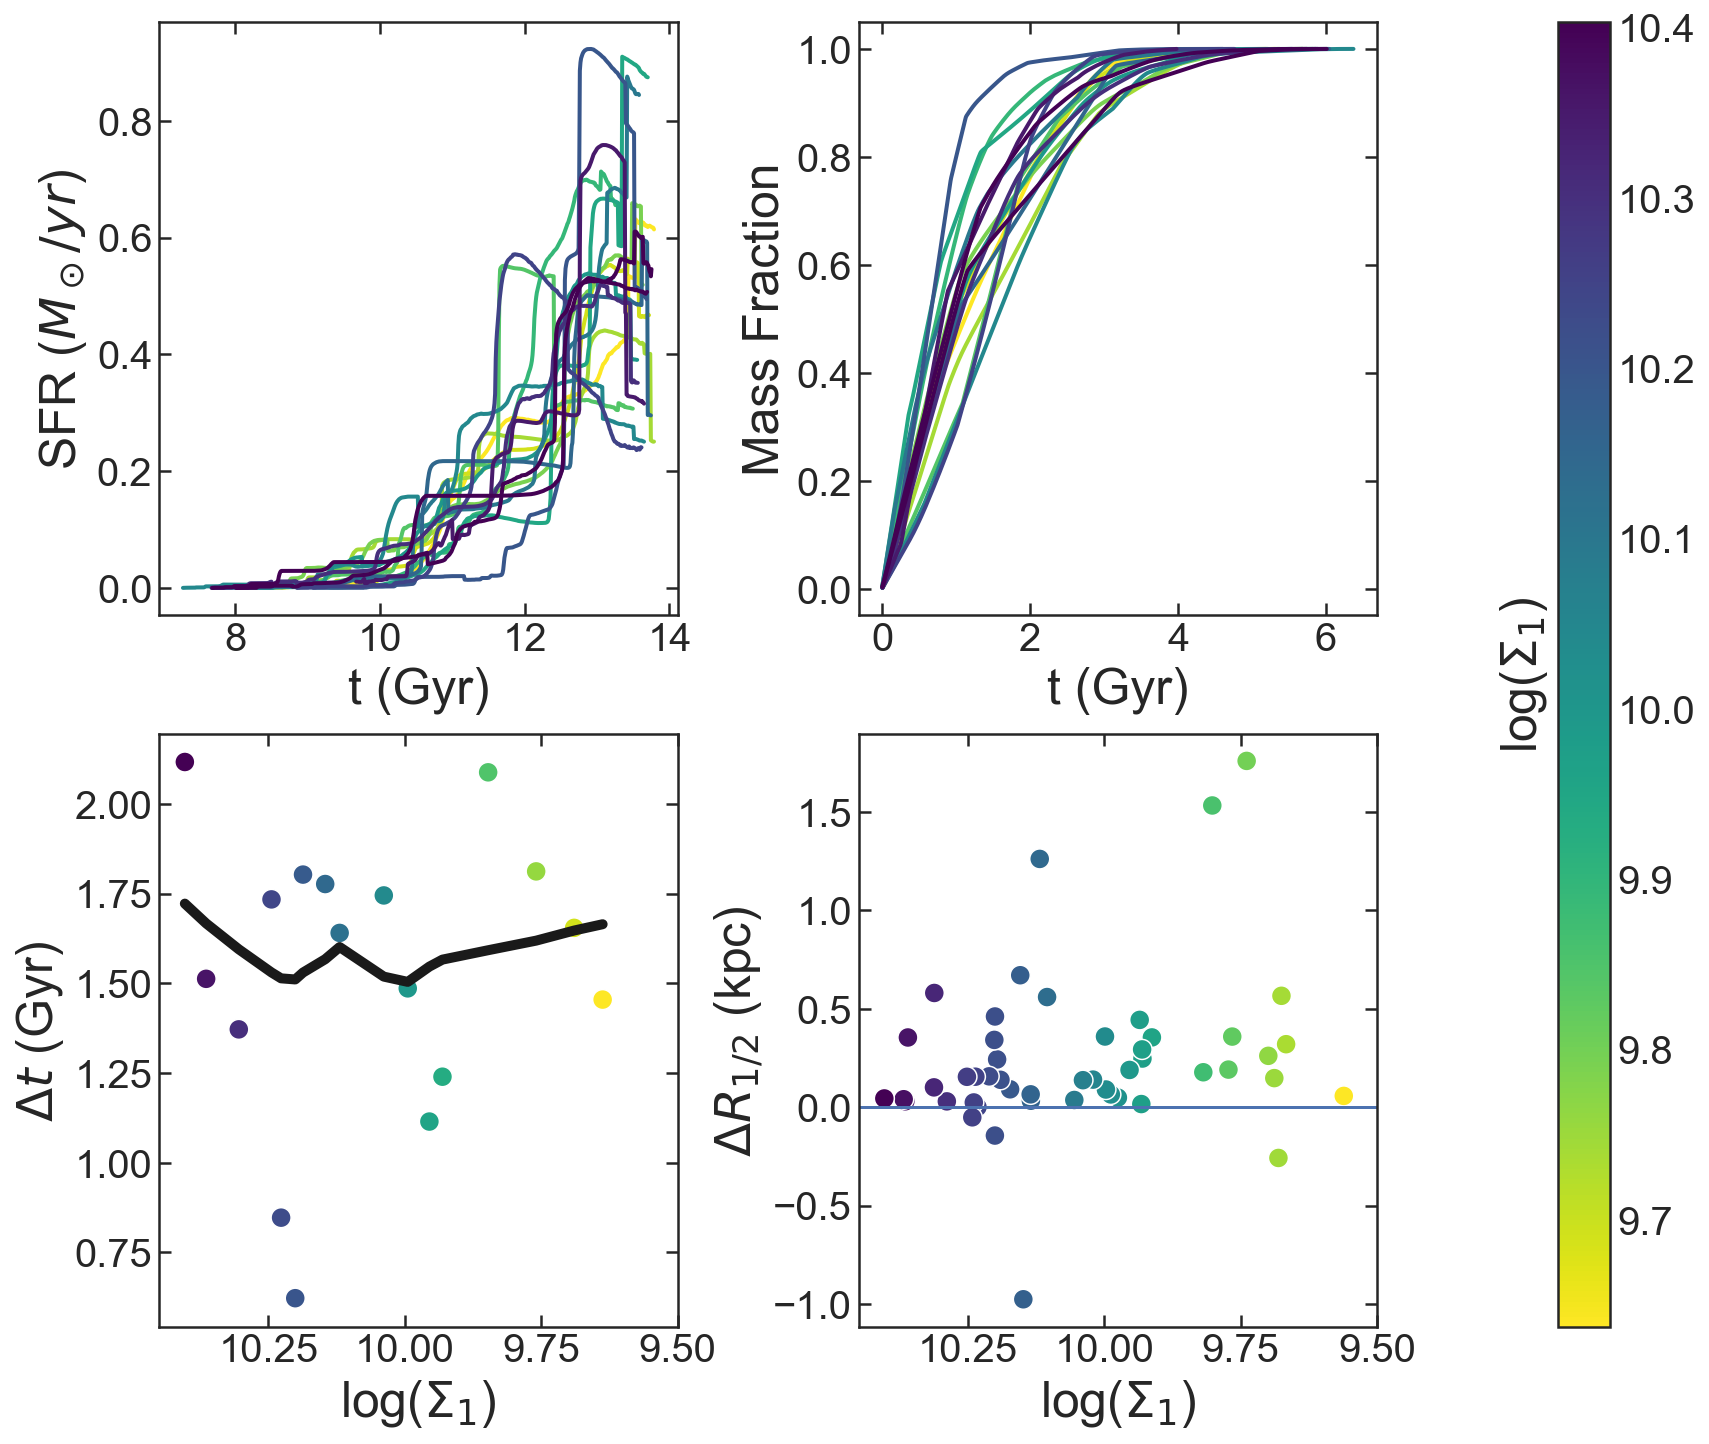

In [10]:
#import colormap
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=15)

IDS = Smdb.index.values

bs = 3

gs = gridspec.GridSpec(2,3, wspace=0.5, width_ratios=[1,1,0.1])

plt.figure(figsize =[13,12])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])

idg = 0
idx = 0
t50 = []
t90 = []
s1 = []
LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

while idg < len(IDS):
    SFH_grid = []
    samp = []
    for ii in IDS[idg:idg+bs]:
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[ii], mdb.id[ii]))

        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[ii]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))
        samp.append(Smdb.Sigma1[ii])

    L,S= Stack_SFH(LBT, SFH_grid)
    
    ax1.plot(L, S/np.trapz(S,L), linewidth = 2,color = np.array(cm.viridis_r(norm(idx),bytes=True)) / 255 )
    ax2.plot(L - min(L), np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])), linewidth = 2, color = np.array(cm.viridis_r(norm(idx),bytes=True)) / 255)
    idx+=1
    
    mb = interp1d(np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])),L - min(L))
    t50.append(mb(0.5))
    t90.append(mb(0.9))        
    s1.append(np.mean(samp))
    
    idg += bs

sea.regplot(np.log10(s1),np.array(t90)-np.array(t50),lowess=True, scatter=False,line_kws={"linewidth" : 5}, color='k')
# for i in range(len(IDS) - bs):
#     sea.scatterplot(np.log10(s1[i]),np.array(t90[i])-np.array(t50[i]), s=100, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255,
#                    ax = ax3)
sea.scatterplot(np.log10(s1),np.array(t90)-np.array(t50), s=100, palette = 'viridis_r',hue = np.log10(s1),legend = False)
plt.xlim(10.45,9.5)

ax1.set_ylabel('SFR ($M_\odot / yr$)', fontsize=25)
ax1.set_xlabel('t (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.set_ylabel('$\Delta t$ (Gyr)', fontsize=25)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax4 = plt.subplot(gs[1,1])
sea.scatterplot(np.log10(Smdb.Sigma1), Smdb.Re_f125 - Smdb.Re_f160, ax = ax4, palette = 'viridis_r', hue = np.log10(Smdb.Sigma1),
               legend = False, s= 100)
plt.axhline(0)
plt.xlim(10.45,9.5)
ax4.set_ylabel('$\Delta R_{1/2}$ (kpc)', fontsize=25)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax5 = plt.subplot(gs[:,2])
cmap = 'viridis_r'
norm = mpl.colors.Normalize(vmin=min(np.log10(s1)), vmax = max(np.log10(s1)))
mpl.colorbar.ColorbarBase(ax5, cmap = cmap, norm=norm, orientation='vertical')
ax5.set_ylabel('log($\Sigma_1$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.yaxis.set_label_position('left')

# plt.savefig('../plots/sfh_dt.pdf', bbox_inches = 'tight')

In [3]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)

    ################   
    SFH = []
    ltimes = []

    for i in range(len(lbt)):
        gdat = sfhgrid[i][sfhgrid[i]>0]

        SFH.append(np.mean(gdat) )
        ltimes.append(lbt[i])

    SFH = np.array(SFH)
    LBT = np.array(ltimes)
    return LBT[SFH**2 > 0], SFH[SFH**2 > 0]

def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))    
        L,S= Stack_SFH(lbt, np.array(sfh)[IDX])
        istack = interp1d(L,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)

    sfh_bs = np.array(sfh_bs)
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84

(7, 13.8)

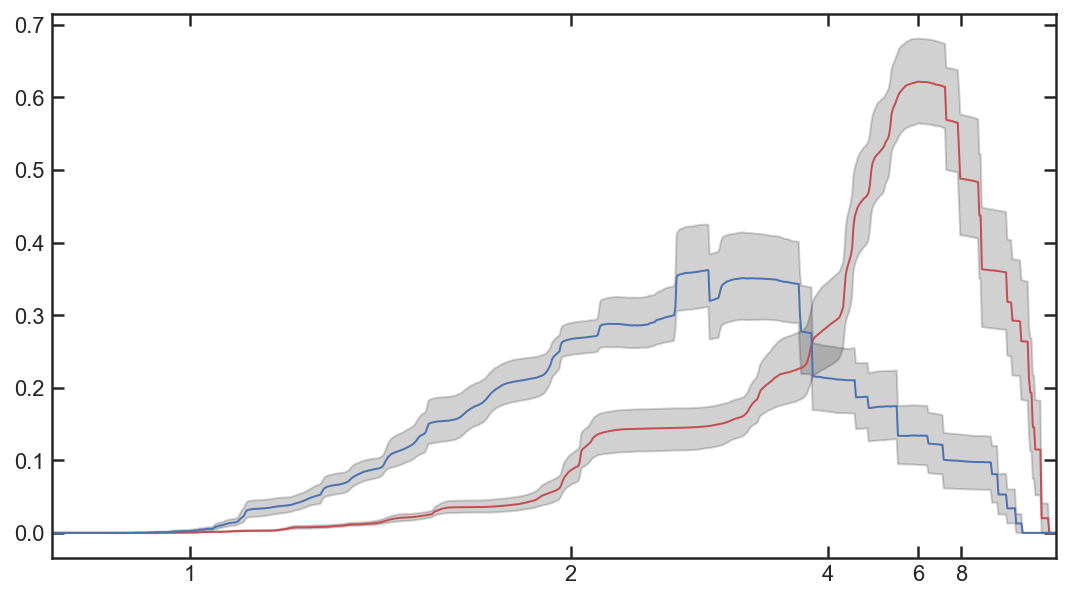

In [605]:
def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))
        newgrid = np.transpose(np.array(sfh)[IDX])
    
        stack = np.zeros(len(lbt))
        for i in range(len(lbt)):   
            stack[i] = np.mean(newgrid[i])        

        sfh_bs.append(stack)
    return np.percentile(sfh_bs,50,axis=0), np.percentile(sfh_bs,16,axis=0), np.percentile(sfh_bs,84,axis=0)

plt.figure(figsize=[9,5])
LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)
SFH_grid = []

for i in mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(LBT, S,'r', linewidth=1)
plt.fill_between(LBT, S16, S84,color='k', alpha = 0.2)

SFH_grid = []
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 < 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(LBT, S,'b', linewidth=1)
plt.fill_between(LBT, S16, S84,color='k', alpha = 0.2)

plt.xticks(cosmo.lookback_time([1,2,4,6,8]).value,[1,2,4,6,8])
plt.xlim(7,13.8)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


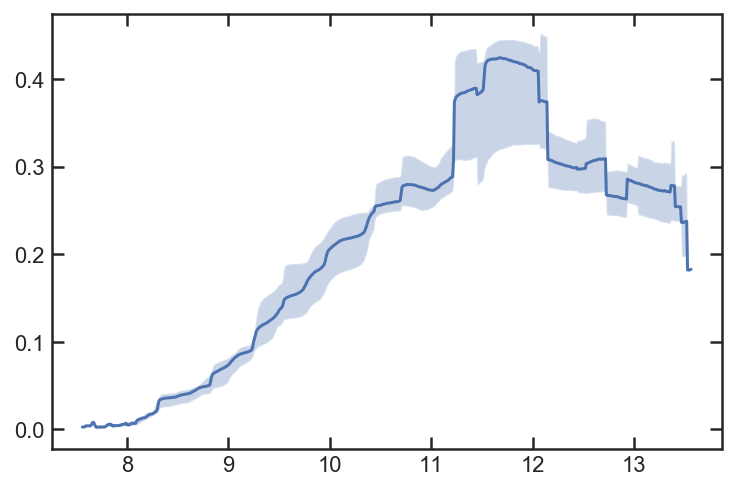

In [630]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)

    ################   
    SFH = []
    ltimes = []

    for i in range(len(lbt)):
        gdat = sfhgrid[i][sfhgrid[i]>0]

        SFH.append(np.mean(gdat) )
        ltimes.append(lbt[i])

    SFH = np.array(SFH)
    LBT = np.array(ltimes)
    return LBT[SFH**2 > 0], SFH[SFH**2 > 0]

def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))    
        L,S= Stack_SFH(lbt, np.array(sfh)[IDX])
        istack = interp1d(L,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)

    sfh_bs = np.array(sfh_bs)
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84


L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 10)

plt.plot(L, S)
plt.fill_between(L,S16,S84, alpha = 0.3)

In [656]:
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')
Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(Smdb))

IDS = Smdb.index.values

bs = 9

LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

for i in range(len(IDS) - bs):
    SFH_grid = []
    
    for ii in range(bs):
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[IDS[i + ii]], mdb.id[IDS[i + ii]]))

        
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[IDS[i + ii]]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

    L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 500)
    
SFH_grid = np.array(SFH_grid)

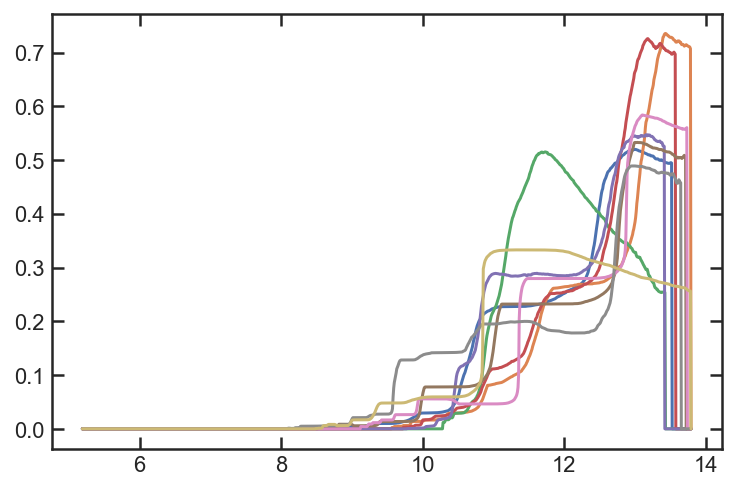

In [657]:
plt.plot(LBT,SFH_grid.T)

In [56]:
def Get_mass_track(field, galaxy, lmass):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))    
    #make mass track
    mt = np.cumsum(sfh[::-1]) * (lbt[1] - lbt[0])*1E9
    
    #put into lookback time
    mt = np.array(mt)[::-1]
    
    #rescale
    mt /= max(mt)
    mt *= 10**lmass
    return lbt, mt

def Get_tq(field, galaxy):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
    lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])
    
    sSFR = np.log10(sfh/mtk)
    
    prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
    prop_a = (cosmo.lookback_time(1E5).value - prop_t) * 1E9
    
    sf_lim = np.log10(1/prop_a)
    q_lim = np.log10(0.2/prop_a)
    
    sf_frm = sSFR - sf_lim
    q_frm = sSFR - q_lim
    
    tq = interp1d(sf_frm, prop_t)(0) - interp1d(q_frm,prop_t)(0)
    th = interp1d(q_frm,prop_a)(0)
    
    return np.array([tq,th*1E-9])


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


(10.45, 9.4)

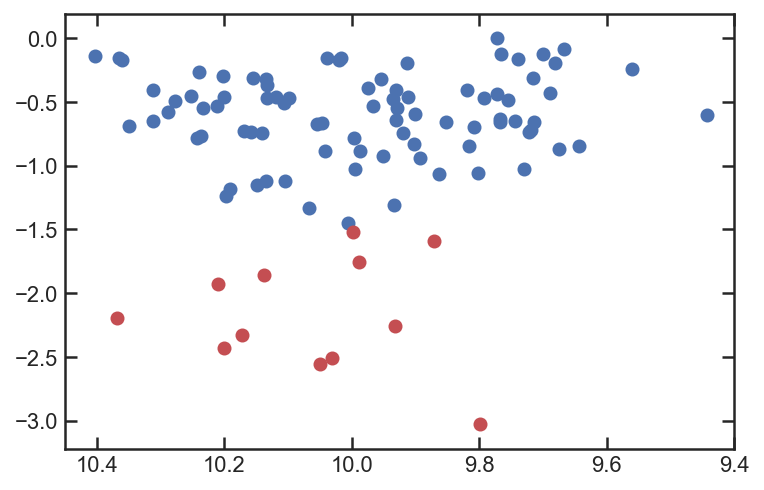

In [92]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
plt.xlim(10.45,9.4)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


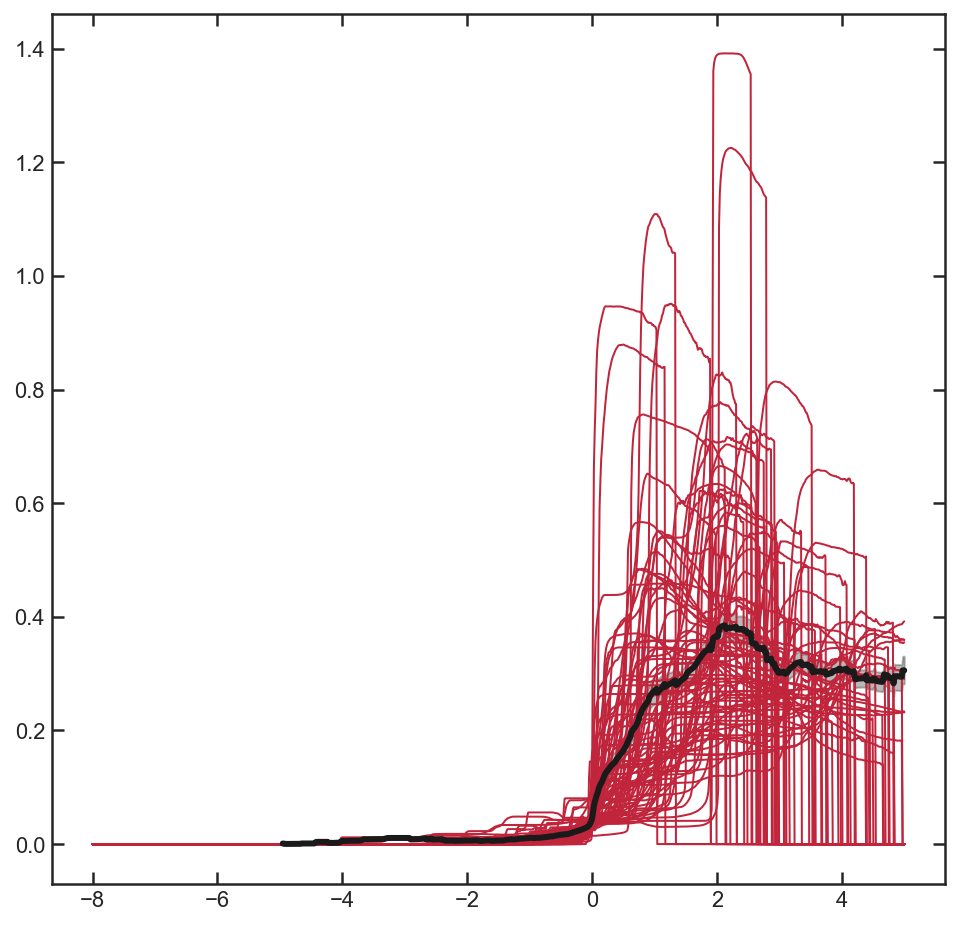

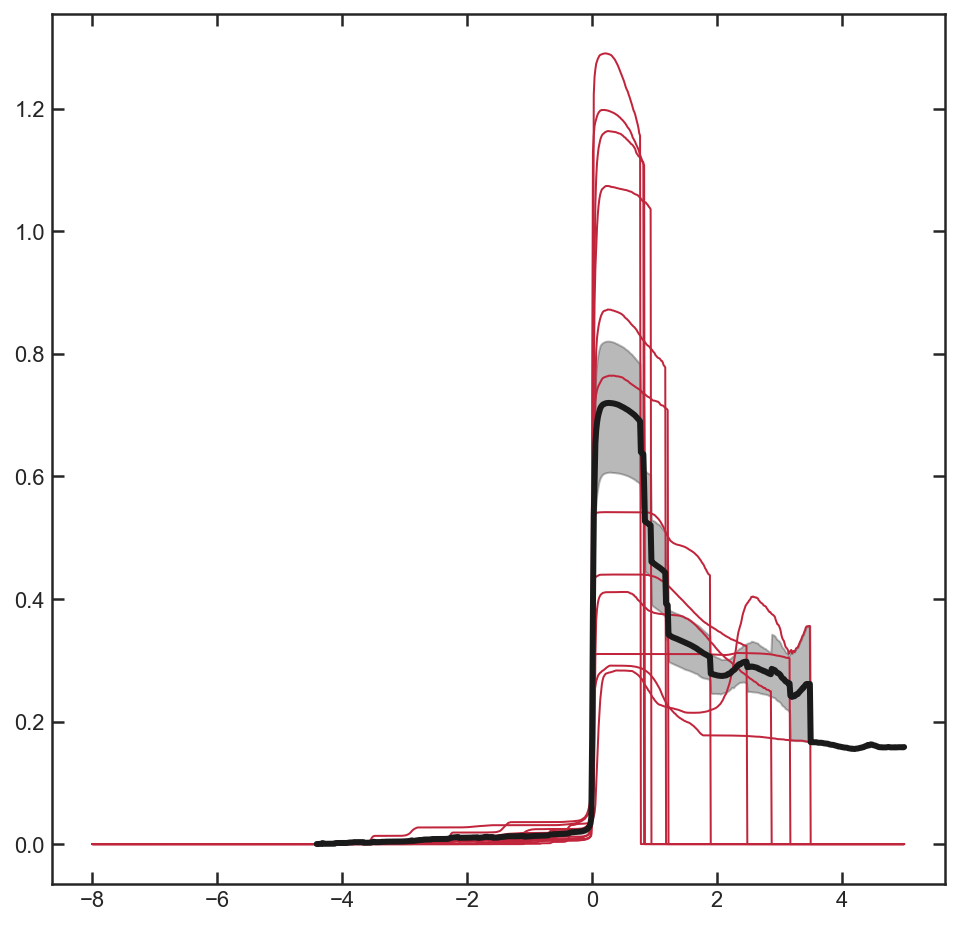

In [93]:
plt.figure(figsize =[8,8])

# LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)
LBT = np.linspace(-8,5,1000)

SFH_grid = []
for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) > -1.5:  
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value - (cosmo.lookback_time(1E5).value - th), sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

        plt.plot(LBT, isfh / np.trapz(isfh, LBT), color = '#C1253C', linewidth = 1)
    
L_lz,S_lz,S16_lz,S84_lz = Stack_SFH_bs(LBT, SFH_grid, its = 1000)
plt.plot(L_lz, S_lz, 'k', linewidth = 3)
plt.fill_between(L_lz, S16_lz, S84_lz,color = 'k', alpha = 0.3)

plt.figure(figsize =[8,8])

SFH_grid = []
for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) < -1.5:  
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value - (cosmo.lookback_time(1E5).value - th), sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

        plt.plot(LBT , isfh / np.trapz(isfh, LBT), color = '#C1253C', linewidth = 1)
       
    
L_hz,S_hz,S16_hz,S84_hz = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(L_hz, S_hz, 'k', linewidth = 3)
plt.fill_between(L_hz, S16_hz, S84_hz,color = 'k', alpha = 0.3)

In [65]:
cosmo.lookback_time(1.25),cosmo.lookback_time(1E5) - cosmo.age(1.25)

(<Quantity 8.82446898 Gyr>, <Quantity 8.8244689 Gyr>)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


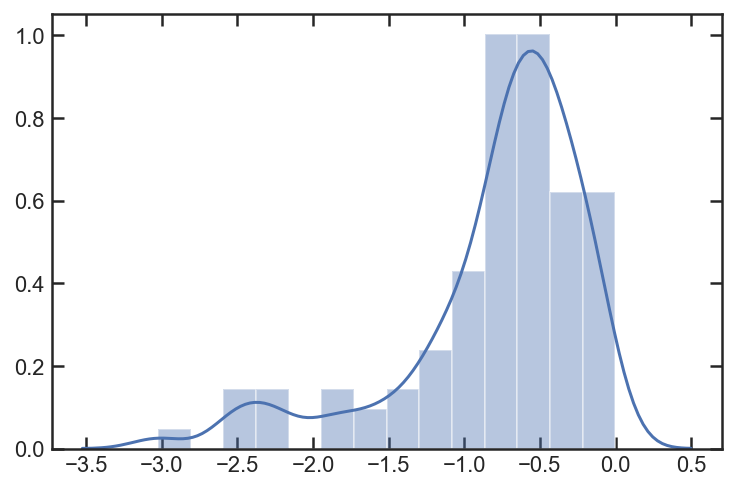

In [91]:
trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th)**2 > 0:
#         print(tq,th,i)
        trk.append(np.log10(tq/th)) 

sea.distplot(trk)

In [90]:
mdb.id[45]

19148